In [19]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from math import sqrt
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout, Dense, LSTM, Bidirectional
import random
import optuna
from optuna.samplers import TPESampler
from keras_tuner import BayesianOptimization


import warnings # filter warnings
warnings.filterwarnings('ignore')

In [20]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [57]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [21]:
# Define the selected exogenous variables and target variable.
features = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]
target = df1['Close']

In [22]:
# Split data into training and testing sets, same ratio applied in SARIMAX.
train_size = int(0.85 * len(features))
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Initialize and fit RobustScalers to scale data with reduced sensitivity to outliers.
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on training data and transform both training and test data.
X_train_scaled = scaler_X.fit_transform(X_train) # Fit scaler on training features and transform.
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)) # Fit scaler on training target and transform.

# Transform test data without fitting again to avoid data leakage.
X_test_scaled = scaler_X.transform(X_test) # Transform test features using the scaler fitted on training data.
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)) # Transform test target using the scaler fitted on training data

# Print minimum and maximum values of the scaled training and test data for verification.
print("Scaled Training Features - Min:", X_train_scaled.min(), "Max:", X_train_scaled.max())
print("Scaled Training Target - Min:", y_train_scaled.min(), "Max:", y_train_scaled.max())
print("Scaled Test Features - Min:", X_test_scaled.min(), "Max:", X_test_scaled.max())
print("Scaled Test Target - Min:", y_test_scaled.min(), "Max:", y_test_scaled.max())

Scaled Training Features - Min: -5.4955652189278625 Max: 9.795796286704956
Scaled Training Target - Min: -3.526234546763028 Max: 2.4845799166596207
Scaled Test Features - Min: -3.5237835824322223 Max: 29.172000533821247
Scaled Test Target - Min: -3.526234546763028 Max: 2.4845799166596207


## Sequence Length = 4 

In [95]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 4  # Number of time steps used for target prediction, 4 weeks.

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (872, 4, 5)
Reshaped y_train_seq shape: (872, 1)
Reshaped X_test_seq shape: (151, 4, 5)
Reshaped  y_test_seq shape: (151, 1)


### 1. Random Search (Two Layers - Model 1)

In [63]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the Bidirectional LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(Bidirectional(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(Bidirectional(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.0401628017425537
Final Validation Loss: 1.4482694864273071
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.675849676132202
Final Validation Loss: 2.7364742755889893
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.9912617206573486
Final Validation Loss: 1.6865462064743042
Running combination 4

In [143]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 375ms/step - loss: 2.2819 - val_loss: 1.3186
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.8077 - val_loss: 1.3202
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.7703 - val_loss: 1.3182
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.6061 - val_loss: 1.3174
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.7708 - val_loss: 1.3179
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.6302 - val_loss: 1.3186
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.6718 - val_loss: 1.3167
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.5360 - val_loss: 1.3155
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.5296 - val_loss: 1.3155
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.4958 - val_loss: 1.3140
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.5587 - val_loss: 1.3143
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.5675 - val_loss: 1.3165

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.01927680521258943
Test RMSE: 0.022653611947151365
Training MAE: 0.01394871044667082
Test MAE: 0.017290756246876142
Directional Accuracy on Training Data: 68.77152698048221%
Directional Accuracy on Test Data: 63.33333333333333%


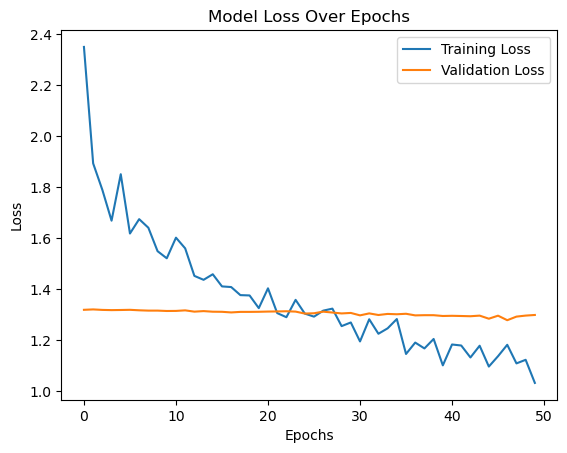

In [144]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [159]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.9945792555809021
Final Validation Loss: 1.3674660921096802
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 9.850749015808105
Final Validation Loss: 9.737322807312012
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.9703609943389893
Final Valida

In [173]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - loss: 37.3507 - val_loss: 33.2185
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 32.7645 - val_loss: 29.1651
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 28.5129 - val_loss: 25.3660
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 24.7485 - val_loss: 21.9940
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 21.3309 - val_loss: 19.0746
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 18.4128 - val_loss: 16.6271
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 16.0053 - val_loss: 14.5685
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 14.0694 - val_loss: 12.8127
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 12.4112 - val_loss: 11.3576
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 10.9405 - val_loss: 10.1193
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 9.7646 - val_loss: 9.0734
Epoch 12/100
28/28 ━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.02040375046327785
Test RMSE: 0.022547003486693928
Training MAE: 0.014785564160326317
Test MAE: 0.01730516543657938
Directional Accuracy on Training Data: 64.52353616532722%
Directional Accuracy on Test Data: 55.333333333333336%


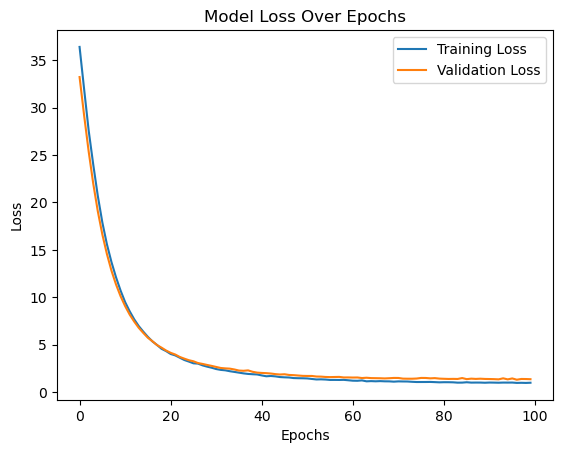

In [174]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [71]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an Bidirectional LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add Bidirectional LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add Bidirectional LSTM layer with specified hyperparameters.
        model.add(Bidirectional(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        )))
        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-21 12:09:04,360] A new study created in memory with name: no-name-fd479281-4855-4085-aa2d-79cc7e479b3b
[I 2024-11-21 12:09:42,481] Trial 0 finished with value: 2.52616024017334 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.52616024017334.
[I 2024-11-21 12:10:15,360] Trial 1 finished with value: 8.451830863952637 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 2.52616024017334.
[I 2024-11-21 12:11:34,158] Trial 2 finished with value: 9.088482856750488 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_

Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.09256022071058256, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-06, 'clipnorm': 1.0, 'units': 64, 'num_layers': 2, 'epochs': 200, 'batch_size': 120}
Best validation loss: 1.1075998544692993


In [167]:
# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.0005,
    'l2_lambda': 0.09256022071058256,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - loss: 5.3131 - val_loss: 2.8383
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.9272 - val_loss: 2.7695
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.0262 - val_loss: 2.7005
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.5541 - val_loss: 2.6267
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.4671 - val_loss: 2.5600
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.3213 - val_loss: 2.4983
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.4590 - val_loss: 2.4347
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.1665 - val_loss: 2.3758
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 3.2483 - val_loss: 2.3175
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.1562 - val_loss: 2.2608
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.0474 - val_loss: 2.2064
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.8878 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Bidirectional LSTM Model Performance:
Training RMSE: 0.020163059678837955
Test RMSE: 0.02310567725338841
Training MAE: 0.014614489045592616
Test MAE: 0.017749095216032178
Directional Accuracy on Training Data: 64.75315729047072%
Directional Accuracy on Test Data: 58.666666666666664%


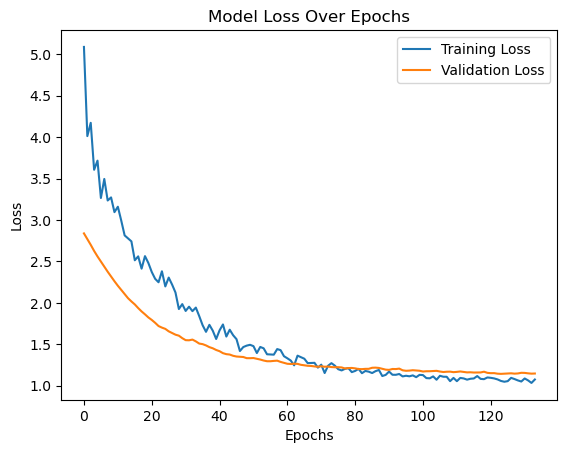

In [168]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [75]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add Bidirectional LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(Bidirectional(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="bi_lstm_tuner_dir",  # Directory to store tuning results.
    project_name="bidirectional_lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 38s]

Best val_loss So Far: 1.2882755994796753
Total elapsed time: 00h 24m 53s
Built model with params: dropout_rate=0.3, recurrent_dropout=0.2, l2_lambda=0.06915775071287864, learning_rate=0.001, learning_rate_decay=1e-05, clipnorm=1.0, units=128, num_layers=1, batch_size=256
Best hyperparameters: {'dropout_rate': 0.3, 'recurrent_dropout': 0.2, 'l2_lambda': 0.06915775071287864, 'learning_rate': 0.001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 128, 'num_layers': 1, 'batch_size': 256}
Best batch size: 256


In [175]:
# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.06915775071287864,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - loss: 3.8267 - val_loss: 2.6097
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 3.3198 - val_loss: 2.5594
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.0101 - val_loss: 2.4757
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.9975 - val_loss: 2.4150
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2.8525 - val_loss: 2.3626
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 2.6537 - val_loss: 2.2906
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.5933 - val_loss: 2.2361
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.6783 - val_loss: 2.1935
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.4061 - val_loss: 2.1298
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.4158 - val_loss: 2.0819
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.2939 - val_loss: 2.0457
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.4072 - val_l

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Bidirectional LSTM Model Performance:
Training RMSE: 0.020148026939146094
Test RMSE: 0.023043328613087593
Training MAE: 0.014609791264966454
Test MAE: 0.01759662571076403
Directional Accuracy on Training Data: 61.76808266360505%
Directional Accuracy on Test Data: 53.333333333333336%


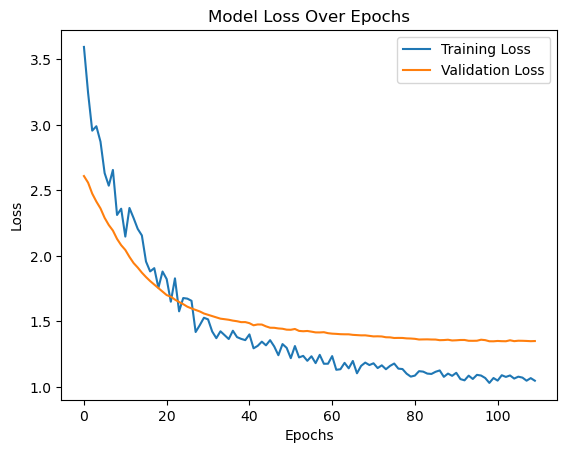

In [176]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation on the best performer (Model 1)

In [96]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step
Fold 1 RMSE: 1.3896110979323613
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Fold 2 RMSE: 0.9389532433948785
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 3 RMSE: 0.7835146073949233
Fold 4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 4 RMSE: 1.1034604945276574
Average RMSE from TSCV: 1.0538848608124551


In [97]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 50    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Rolling window RMSE: 1.2044222343233661
Rolling window starting at index 50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Rolling window RMSE: 1.2580701504716612
Rolling window starting at index 100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Rolling window RMSE: 0.8726057825622852
Rolling window starting at index 150
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Rolling window RMSE: 0.7369876697492806
Rolling window starting at index 200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Rolling window RMSE: 0.7505392494598536
Rolling window starting at index 250
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Rolling window RMSE: 0.8738888936614156
Rolling window starting at index 300
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Rolling window RMSE: 0.8286668841326819
Rolling window starting at index 350
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Rolling window RMSE: 0.5116506426055647
Rolling window starting at index 400
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Rolling window RMSE: 0.750

In [98]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.026300152727175025
Descaled Validation Loss: 0.03006664048345614


In [99]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.029743845966354186, 0.02060582042551499, 0.017453978709012396, 0.023941547180011288]
Descaled FRWCV RMSE Values: [0.0259887564932665, 0.02707657960128501, 0.01926048762912935, 0.01651054825448439, 0.016785334725566817, 0.019286505376024325, 0.01836953505381446, 0.011941371242248856, 0.016787368151893727, 0.022872804447554993, 0.028313865544805163]
Average Descaled TSCV RMSE: 0.022936298070223217
Average Descaled FRWCV RMSE: 0.020290286956370324


### Bi-LSTM - Sequence Length = 4

| Metrics      | Model 1     | Model 2     | Model 3     | Model 4     |
|--------------|-------------|-------------|-------------|-------------|
| **Train RMSE** | 0.019276805 | 0.02040375  | 0.02016306  | 0.020148027 |
| **Test RMSE**  | 0.022653612 | 0.022547003 | 0.023105677 | 0.023043329 |
| **Train MAE**  | 0.01394871  | 0.014785564 | 0.014614489 | 0.014609791 |
| **Test MAE**   | 0.017290756 | 0.017305165 | 0.017749095 | 0.017596626 |
| **Train Loss** | 1.03155005  | 0.994579256 | 1.074562073 | 1.047194958 |
| **Val Loss**   | 1.298350811 | 1.367466092 | 1.14686656  | 1.350077271 |
| **Train DA**   | 69%         | 65%         | 65%         | 62%         |
| **Test DA**    | 63%         | 55%         | 59%         | 53%         |

- By oberserving the metric table and the train and validation loss plot it indicates that the **Model 1 is the best performer with sequence length of 4**. The model present lowest and most balanced scores.
- 

### Descaled Metrics for Sequence Length = 4

#### TSCV RMSE Values
| Fold | RMSE              |
|------|-------------------|
| 1    | 0.029743845966354 |
| 2    | 0.020605820425515 |
| 3    | 0.017453978709012 |
| 4    | 0.023941547180011 |

**Average TSCV RMSE**: **0.022936298070223217**

- The model 1 shows close rmse values across Fold 2,3 and 4, but with the highest RMSE (compared to the average) struggles to generalize in the first fold.

---

#### FRWCV RMSE Values
| Window | RMSE              |
|--------|-------------------|
| 1      | 0.025988756493267 |
| 2      | 0.027076579601285 |
| 3      | 0.019260487629129 |
| 4      | 0.016510548254484 |
| 5      | 0.016785334725567 |
| 6      | 0.019286505376024 |
| 7      | 0.018369535053814 |
| 8      | 0.011941371242249 |
| 9      | 0.016787368151894 |
| 10     | 0.022872804447555 |
| 11     | 0.028313865544805 |

**Average FRWCV RMSE**: **0.020290286956370324**

- The model shows consistent performance in majority of the windows. However, within the range of 11 windows the model showed instalibity across the the 1, 2, 10 and 11, suggesting that the model struggles at the start and at the end of the series.
---

#### Training and Validation Loss
| Metric              | Loss              |
|---------------------|-------------------|
| **Training Loss**   | 0.026300152727175 |
| **Validation Loss** | 0.030066640483456 |

## Sequence Length = 12 

In [101]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 12  # Number of time steps used for target prediction, 12 weeks (Quarterly).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (864, 12, 5)
Reshaped y_train_seq shape: (864, 1)
Reshaped X_test_seq shape: (143, 12, 5)
Reshaped  y_test_seq shape: (143, 1)


### 1. Random Search (Two Layers - Model 1)

In [81]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the Bidirectional LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(Bidirectional(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(Bidirectional(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 0.9834921956062317
Final Validation Loss: 1.9184983968734741
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.968540906906128
Final Validation Loss: 2.0144660472869873
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.3766080141067505
Final Validation Loss: 1.7862027883529663
Running combination 4

In [204]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - loss: 2.6441 - val_loss: 1.3438
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 2.1957 - val_loss: 1.3649
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 1.8825 - val_loss: 1.3544
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 1.7346 - val_loss: 1.3545
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 1.6418 - val_loss: 1.3574
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 1.6060 - val_loss: 1.3609
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 1.6432 - val_loss: 1.3513
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 1.6096 - val_loss: 1.3703
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 1.5561 - val_loss: 1.3543
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 1.4200 - val_loss: 1.3590
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 1.5284 - val_loss: 1.3543
Final Training Loss: 1.5157690048217773
Final Validation Loss: 1.35425734

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.020352359437582138
Test RMSE: 0.02325245424227265
Training MAE: 0.014758603891206033
Test MAE: 0.017485258679233933
Directional Accuracy on Training Data: 57.12630359212051%
Directional Accuracy on Test Data: 61.267605633802816%


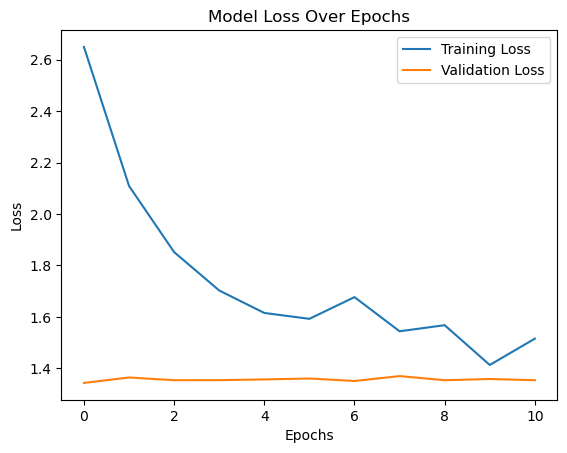

In [205]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [85]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.9754722118377686
Final Validation Loss: 2.0911011695861816
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 10.10887336730957
Final Validation Loss: 10.0421142578125
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 3.1304454803466797
Final Validat

In [208]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - loss: 3.8124 - val_loss: 1.6461
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 2.5561 - val_loss: 1.6421
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 1.9560 - val_loss: 1.6401
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 1.9972 - val_loss: 1.6354
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - loss: 1.9751 - val_loss: 1.6496
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 2.0098 - val_loss: 1.6388
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 1.9596 - val_loss: 1.6576
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 1.8839 - val_loss: 1.6409
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 1.7838 - val_loss: 1.6466
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 1.6646 - val_loss: 1.6534
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 1.6981 - val_loss: 1.6605
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 1.

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 759ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.02040908312912967
Test RMSE: 0.023387993740669077
Training MAE: 0.014706573388705393
Test MAE: 0.017489572148624653
Directional Accuracy on Training Data: 50.63731170336037%
Directional Accuracy on Test Data: 45.07042253521127%


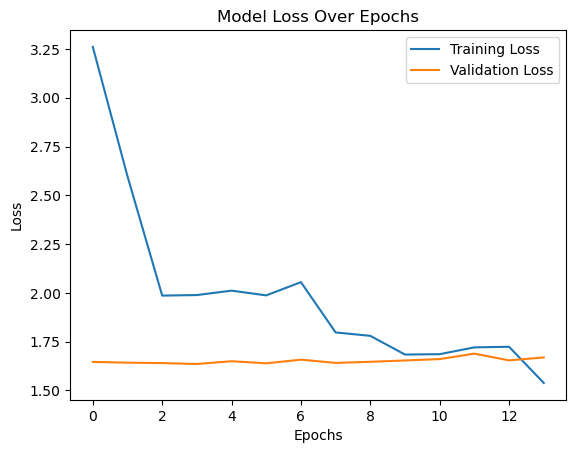

In [209]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [89]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an Bidirectional LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add Bidirectional LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add Bidirectional LSTM layer with specified hyperparameters.
        model.add(Bidirectional(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        )))
        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-21 13:34:28,234] A new study created in memory with name: no-name-224e4cc6-be37-45cc-bfa8-2bfe92f41296
[I 2024-11-21 13:35:16,168] Trial 0 finished with value: 2.5719268321990967 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.5719268321990967.
[I 2024-11-21 13:36:00,682] Trial 1 finished with value: 8.592062950134277 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 2.5719268321990967.
[I 2024-11-21 13:38:25,298] Trial 2 finished with value: 9.10501480102539 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2,

Best hyperparameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.017972227612034528, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 1.0, 'units': 128, 'num_layers': 1, 'epochs': 200, 'batch_size': 120}
Best validation loss: 1.1971074342727661


In [212]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.017972227612034528,
    'epochs': 200,
    'dropout_rate': 0.30000000000000004,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - loss: 2.6742 - val_loss: 1.4562
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 2.6519 - val_loss: 1.4225
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 2.2608 - val_loss: 1.4134
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 2.1918 - val_loss: 1.4077
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.8884 - val_loss: 1.3826
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 1.8195 - val_loss: 1.3862
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 1.7956 - val_loss: 1.3656
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.8013 - val_loss: 1.3556
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 1.7931 - val_loss: 1.3623
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.6221 - val_loss: 1.3565
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.7758 - val_loss: 1.3347
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 1.6360 - val_l

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.020123815945724845
Test RMSE: 0.023313898718885347
Training MAE: 0.014573090806879742
Test MAE: 0.01754696659300368
Directional Accuracy on Training Data: 67.32329084588645%
Directional Accuracy on Test Data: 56.33802816901409%


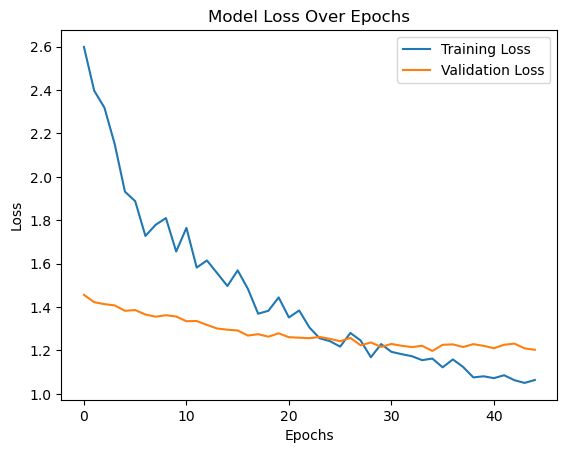

In [213]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [93]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add Bidirectional LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(Bidirectional(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="bi_lstm_tuner_dir",  # Directory to store tuning results.
    project_name="bidirectional_lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 01m 34s]
val_loss: 1.8038148880004883

Best val_loss So Far: 1.2856566905975342
Total elapsed time: 00h 26m 17s
Built model with params: dropout_rate=0.3, recurrent_dropout=0.1, l2_lambda=0.0011618560517582955, learning_rate=0.0001, learning_rate_decay=1e-05, clipnorm=5.0, units=32, num_layers=1, batch_size=32
Best hyperparameters: {'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0011618560517582955, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'batch_size': 32}
Best batch size: 32


In [216]:
# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0001,
    'l2_lambda': 0.0011618560517582955,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 3.3093 - val_loss: 1.3734
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9205 - val_loss: 1.3791
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6640 - val_loss: 1.3887
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4728 - val_loss: 1.4027
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6475 - val_loss: 1.4205
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3713 - val_loss: 1.4388
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3786 - val_loss: 1.4572
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1394 - val_loss: 1.4830
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2787 - val_loss: 1.5072
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0222 - val_loss: 1.5338
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9367 - val_loss: 1.5628
Final Training Loss: 1.9662439823150635
Final Validatio

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.020678643738141867
Test RMSE: 0.024028591790639903
Training MAE: 0.015120515756227419
Test MAE: 0.018071873326611938
Directional Accuracy on Training Data: 47.85631517960602%
Directional Accuracy on Test Data: 47.88732394366197%


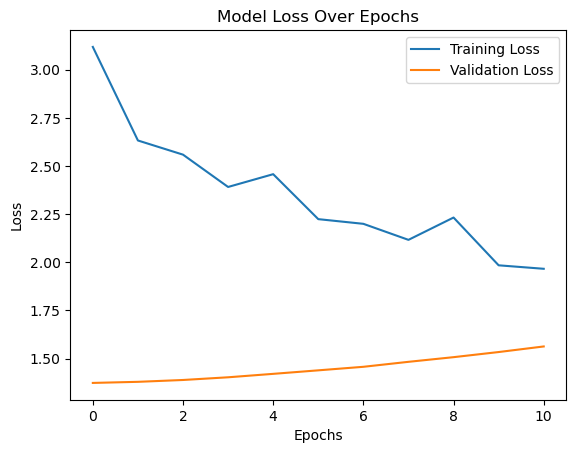

In [217]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation on the best performer (Model 3)

In [102]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.017972227612034528,
    'epochs': 200,
    'dropout_rate': 0.30000000000000004,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
Fold 1 RMSE: 1.4097925851889817
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Fold 2 RMSE: 0.9370116997525367
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 3 RMSE: 0.7934568768221781
Fold 4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 4 RMSE: 1.1173942122905067
Average RMSE from TSCV: 1.0644138435135508


In [103]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 50    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Rolling window RMSE: 1.2702825737589318
Rolling window starting at index 50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Rolling window RMSE: 1.3712644578501214
Rolling window starting at index 100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
Rolling window RMSE: 0.9402857480707364
Rolling window starting at index 150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
Rolling window RMSE: 0.7613590175357237
Rolling window starting at index 200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Rolling window RMSE: 0.8026804523288524
Rolling window starting at index 250
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
Rolling window RMSE: 0.8780831661342899
Rolling window starting at index 300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Rolling window RMSE: 0.8823380103350323
Rolling window starting at index 350
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Rolling window RMSE: 0.4536468287983622
Rolling window starting at index 400
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 617ms/step

In [104]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.027792067397900733
Descaled Validation Loss: 0.032003970661871946


In [105]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.030153067605667206, 0.020566451589015777, 0.017655578905359584, 0.02422408229509641]
Descaled FRWCV RMSE Values: [0.02732421188992925, 0.029371829670683147, 0.02063283972993558, 0.0170047280325463, 0.01784260608730974, 0.01937155297609711, 0.019457828793964703, 0.010765223247268748, 0.017880901521404233, 0.020802309404362233, 0.02997938328319925]
Average Descaled TSCV RMSE: 0.023149795098784745
Average Descaled FRWCV RMSE: 0.020948492239700023


### Bi-LSTM - Sequence Length = 12

| Metrics        | Model 1      | Model 2      | Model 3      | Model 4      |
|----------------|--------------|--------------|--------------|--------------|
| **Train RMSE** | 0.020352359  | 0.020409083  | 0.020123816  | 0.020678644  |
| **Test RMSE**  | 0.023252454  | 0.023387994  | 0.023313899  | 0.024028592  |
| **Train MAE**  | 0.014758604  | 0.014706573  | 0.014573091  | 0.015120516  |
| **Test MAE**   | 0.017485259  | 0.017489572  | 0.017546967  | 0.018071873  |
| **Train Loss** | 1.515769005  | 1.538373232  | 1.063848257  | 1.966243982  |
| **Val Loss**   | 1.354257345  | 1.668971658  | 1.202913284  | 1.562825561  |
| **Train DA**   | 57%          | 51%          | 67%          | 48%          |
| **Test DA**    | 61%          | 45%          | 56%          | 48%          |


According to the metrics the Model 3 does not have the lowest, but the difference is minimal. Also, the lowest val loss and its balance with the training loss. Therefore, **the best model for the sequence length of 12 is the Model 3**.

### Descaled Metrics for Sequence Length = 12

#### TSCV RMSE Values
| Fold | RMSE              |
|------|-------------------|
| 1    | 0.030153067605667 |
| 2    | 0.020566451589016 |
| 3    | 0.017655578905360 |
| 4    | 0.024224082295096 |

**Average TSCV RMSE**: **0.023149795098784745**

- The TSCV shows that the model has good generalization across different folds, however the first fold presents much higher rmse than the next ones. This point could suggest that the model improves when more data is available. 

---

#### FRWCV RMSE Values
| Window | RMSE              |
|--------|-------------------|
| 1      | 0.027324211889929 |
| 2      | 0.029371829670683 |
| 3      | 0.020632839729936 |
| 4      | 0.017004728032546 |
| 5      | 0.017842606087310 |
| 6      | 0.019371552976097 |
| 7      | 0.019457828793965 |
| 8      | 0.010765223247269 |
| 9      | 0.017880901521404 |
| 10     | 0.020802309404362 |
| 11     | 0.029979383283199 |

**Average FRWCV RMSE**: **0.020948492239700023**

- According to the CV score, it shows that the model does not generalize well in the first and second window so as in the last one (highest rmse, also above avg). Those windows might have spikes, or quick changes that might affect the model performance.

---

#### Training and Validation Loss
| Metric              | Loss              |
|---------------------|-------------------|
| **Training Loss**   | 0.027792067397901 |
| **Validation Loss** | 0.032003970661872 |

## Sequence Length = 26 

In [74]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 26  # Number of time steps used for target prediction, 26 weeks (Six-Months).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (850, 26, 5)
Reshaped y_train_seq shape: (850, 1)
Reshaped X_test_seq shape: (129, 26, 5)
Reshaped  y_test_seq shape: (129, 1)


### 1. Random Search (Two Layers - Model 1)

In [101]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the Bidirectional LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(Bidirectional(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(Bidirectional(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 0.9537740349769592
Final Validation Loss: 1.4624109268188477
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.174684524536133
Final Validation Loss: 2.2529098987579346
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 2.0906496047973633
Final Validation Loss: 1.4887031316757202
Running combination 4

In [243]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 416ms/step - loss: 2.7781 - val_loss: 1.4061
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: 1.8671 - val_loss: 1.4024
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - loss: 1.6810 - val_loss: 1.4163
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - loss: 1.7352 - val_loss: 1.4091
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 1.7118 - val_loss: 1.4205
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 1.6997 - val_loss: 1.4115
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - loss: 1.5452 - val_loss: 1.4059
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 1.5251 - val_loss: 1.4045
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 1.4877 - val_loss: 1.4166
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - loss: 1.4735 - val_loss: 1.4166
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 1.5070 - val_loss: 1.4324
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 1.3968 - val_l

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.020452622753484646
Test RMSE: 0.02422487657156922
Training MAE: 0.014822926157638415
Test MAE: 0.01845008643628332
Directional Accuracy on Training Data: 59.36395759717315%
Directional Accuracy on Test Data: 61.71875%


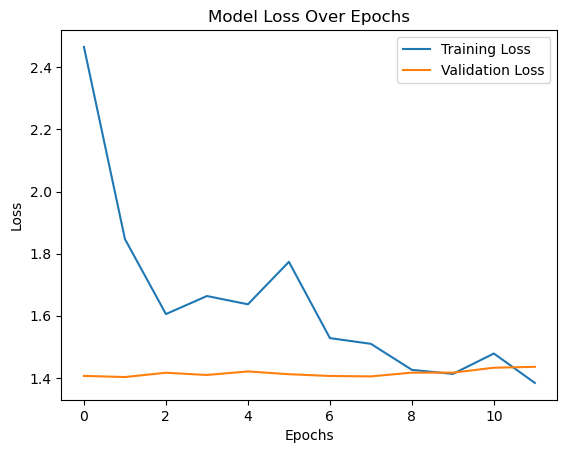

In [244]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [102]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.140710711479187
Final Validation Loss: 2.0429165363311768
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 10.075706481933594
Final Validation Loss: 10.179563522338867
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 3.224580764770508
Final Valida

In [277]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 152ms/step - loss: 4.0863 - val_loss: 1.5512
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 3.3902 - val_loss: 1.5489
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 2.9826 - val_loss: 1.5500
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 3.1509 - val_loss: 1.5489
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 3.1485 - val_loss: 1.5461
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 2.6086 - val_loss: 1.5539
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 2.5906 - val_loss: 1.5494
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 2.6097 - val_loss: 1.5542
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 2.4634 - val_loss: 1.5996
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 2.4549 - val_loss: 1.6357
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 2.4070 - val_loss: 1.6851
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/st

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.02075624148006248
Test RMSE: 0.024168990097055004
Training MAE: 0.014930610535122426
Test MAE: 0.01807341416803685
Directional Accuracy on Training Data: 57.126030624263834%
Directional Accuracy on Test Data: 60.15625%


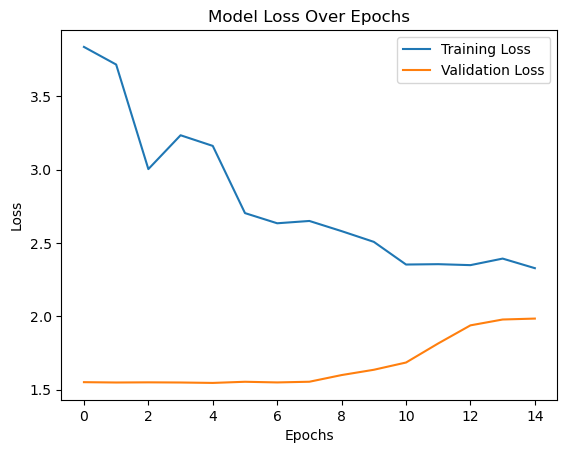

In [278]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [103]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an Bidirectional LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add Bidirectional LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add Bidirectional LSTM layer with specified hyperparameters.
        model.add(Bidirectional(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        )))
        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-21 15:14:10,392] A new study created in memory with name: no-name-5d87a451-79d1-4c67-b7c1-0faf83a531cb
[I 2024-11-21 15:15:05,979] Trial 0 finished with value: 2.2910149097442627 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.2910149097442627.
[I 2024-11-21 15:15:58,437] Trial 1 finished with value: 8.856379508972168 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 2.2910149097442627.
[I 2024-11-21 15:19:33,179] Trial 2 finished with value: 9.756916046142578 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0010012325682668814, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 200, 'batch_size': 64}
Best validation loss: 0.9573647379875183


In [264]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0010012325682668814,
    'epochs': 200,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - loss: 2.2085 - val_loss: 0.9899
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 1.4740 - val_loss: 0.9815
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 2.0398 - val_loss: 0.9888
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 1.5267 - val_loss: 0.9919
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 1.4483 - val_loss: 0.9965
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 1.2707 - val_loss: 0.9651
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 1.1462 - val_loss: 0.9915
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 1.0993 - val_loss: 0.9923
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 1.1186 - val_loss: 0.9825
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 1.0243 - val_loss: 0.9841
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 1.0296 - val_loss: 0.9747
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 7

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.020310553208240392
Test RMSE: 0.02404385153444427
Training MAE: 0.014810702051996267
Test MAE: 0.01836590307700848
Directional Accuracy on Training Data: 65.37102473498233%
Directional Accuracy on Test Data: 70.3125%


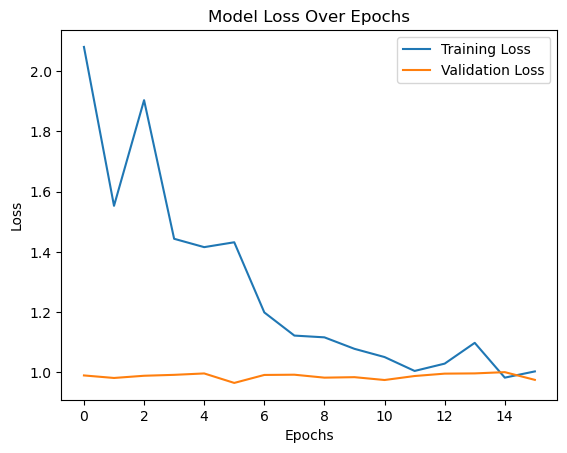

In [265]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [104]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add Bidirectional LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(Bidirectional(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="bi_lstm_tuner_dir",  # Directory to store tuning results.
    project_name="bidirectional_lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 22s]
val_loss: 1.192940354347229

Best val_loss So Far: 1.1341201066970825
Total elapsed time: 00h 36m 37s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.0031453584943524474, learning_rate=0.0005, learning_rate_decay=0.0, clipnorm=1.0, units=32, num_layers=1, batch_size=32
Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0031453584943524474, 'learning_rate': 0.0005, 'learning_rate_decay': 0.0, 'clipnorm': 1.0, 'units': 32, 'num_layers': 1, 'batch_size': 32}
Best batch size: 32


In [266]:
# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0.0,
    'learning_rate': 0.0005,
    'l2_lambda': 0.0031453584943524474,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 3.1656 - val_loss: 1.2981
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.9112 - val_loss: 1.2850
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.5299 - val_loss: 1.2656
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.2021 - val_loss: 1.2715
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.2296 - val_loss: 1.2659
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9399 - val_loss: 1.2899
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.0035 - val_loss: 1.2808
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8858 - val_loss: 1.2890
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7821 - val_loss: 1.3328
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.8007 - val_loss: 1.3361
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7244 - val_loss: 1.3372
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Bidirectional LSTM Model Performance:
Training RMSE: 0.020647759153003202
Test RMSE: 0.02472630722329989
Training MAE: 0.015050904674622136
Test MAE: 0.018521613442943955
Directional Accuracy on Training Data: 48.88103651354535%
Directional Accuracy on Test Data: 53.90625%


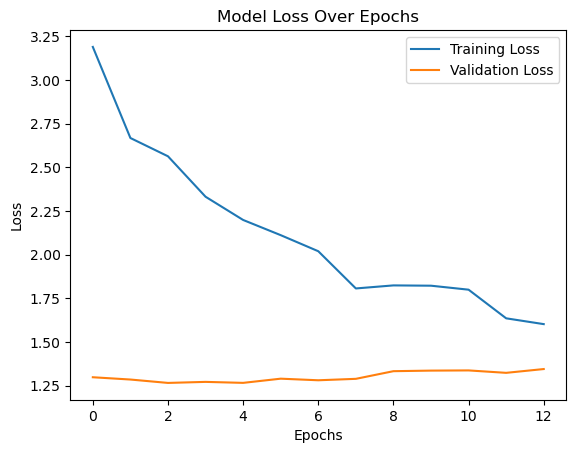

In [267]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation on the best performer (Model 3)

In [76]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0010012325682668814,
    'epochs': 200,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
Fold 1 RMSE: 1.4107724367795964
Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Fold 2 RMSE: 0.9449380398690184
Fold 3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Fold 3 RMSE: 0.7583929364440785
Fold 4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Fold 4 RMSE: 1.1435826233132085
Average RMSE from TSCV: 1.0644215091014755


In [80]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.020654140907753214
Descaled Validation Loss: 0.02599375840115013


In [62]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 50    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
Rolling window RMSE: 1.0294255051394503
Rolling window starting at index 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Rolling window RMSE: 1.5190615331025563
Rolling window starting at index 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Rolling window RMSE: 1.0147496059848244
Rolling window starting at index 150
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Rolling window RMSE: 0.787687413360344
Rolling window starting at index 200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Rolling window RMSE: 0.7783649393409082
Rolling window starting at index 250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Rolling window RMSE: 0.9636073778766131
Rolling window starting at index 300
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Rolling window RMSE: 0.6214014864717632
Rolling window starting at index 350
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
Rolling window RMSE: 0.38554893159300385
Rolling window starting at index 400
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
Ro

In [84]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.030172936135131667, 0.020727174624685762, 0.01694458456783409, 0.024755106810457516]
Descaled FRWCV RMSE Values: [0.012402638138643316, 0.010812899297552279, 0.00892126405822927, 0.002941897227695383, 0.018125817011027667, 0.015532452457700612, 0.006497802913267055, 0.006921673671553334, 0.01109245671594164, 0.07260494288853689]
Average Descaled TSCV RMSE: 0.02314995053452726
Average Descaled FRWCV RMSE: 0.016585384438014744


### Bi-LSTM - Sequence Length = 26

| **Metrics**   | **Model 1**    | **Model 2**    | **Model 3**    | **Model 4**    |
|---------------|----------------|----------------|----------------|----------------|
| **Train RMSE**| 0.020452623    | 0.020756241    | 0.020310553    | 0.020647759    |
| **Test RMSE** | 0.024224877    | 0.02416899     | 0.024043852    | 0.024726307    |
| **Train MAE** | 0.014822926    | 0.014930611    | 0.014810702    | 0.015050905    |
| **Test MAE**  | 0.018450086    | 0.018073414    | 0.018365903    | 0.018521613    |
| **Train Loss**| 1.383493662    | 2.328147888    | 1.003249288    | 1.602082849    |
| **Val Loss**  | 1.435343027    | 1.984609246    | 0.975213945    | 1.344984412    |
| **Train DA**  | 59%            | 57%            | 65%            | 49%            |
| **Test DA**   | 62%            | 60%            | 70%            | 54%            |


The mestrics and plots shows that:
- Model 3 has the lowest RMSE metrics and competitive MAE.
- Also, model 3 presents reasonable DA (70% for the test set).
- The train and val loss shows that model 3 shows good convergence and no signs of over/underfitting.

**To conclude, the optimal model for the sequence length of 26 is the Model 3**.

### Descaled Metrics for Model 3

#### TSCV RMSE Values
| Fold | RMSE              |
|------|-------------------|
| 1    | 0.030172936135132 |
| 2    | 0.020727174624686 |
| 3    | 0.016944584567834 |
| 4    | 0.024755106810458 |

**Average TSCV RMSE**: **0.02314995053452726**

- The model 3 shows consistent performance across Fold 2,3 and 4 (close to the average), but with the highest RMSE (compared to the average) struggles to generalize in the first fold. 

---

#### FRWCV RMSE Values
| Window | RMSE              |
|--------|-------------------|
| 1      | 0.012402638138643 |
| 2      | 0.010812899297552 |
| 3      | 0.008921264058229 |
| 4      | 0.002941897227695 |
| 5      | 0.018125817011028 |
| 6      | 0.015532452457701 |
| 7      | 0.006497802913267 |
| 8      | 0.006921673671553 |
| 9      | 0.011092456715942 |
| 10     | 0.072604942888537 |

**Average FRWCV RMSE**: **0.016585384438014744**

- The model presents lower avg RMSE compare to the TSCV, the cross-validation technique shows that across 9 windows the rmse ranges from 0.002 to 0.018, which indicates good generalization. However, the extremely high value (0.07) suggests that it is struggling to generalize when the last "portion" of the data. 
---

#### Training and Validation Loss
| Metric              | Loss              |
|---------------------|-------------------|
| **Training Loss**   | 0.020654140907753 |
| **Validation Loss** | 0.025993758401150 |



## Sequence Length = 52

In [123]:
# Set the sequence length for LSTM input, representing the number of time steps.
sequence_length = 52  # Number of time steps used for target prediction, 52 weeks (One year).

# Reshape data into sequences for LSTM.
# Initialize empty lists to hold the sequences for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the training data to create sequences of features and corresponding target values.
for i in range(len(X_train_scaled) - sequence_length):
    # Append a sequence of features for the current window.
    X_train_seq.append(X_train_scaled[i:i + sequence_length]) # Sequence of features.
    # Append the target value that comes immediately after the sequence.
    y_train_seq.append(y_train_scaled[i + sequence_length]) # Target value following the sequence.
# Initialize empty lists to hold the sequences for the test set    
X_test_seq, y_test_seq = [], []
# Same process for the test sets.
for i in range(len(X_test_scaled) - sequence_length):
    # Append a sequence of features for the current window in the test set.
    X_test_seq.append(X_test_scaled[i:i + sequence_length])
    # Append the target value immediately after the sequence in the test set.
    y_test_seq.append(y_test_scaled[i + sequence_length])

# Convert lists to numpy arrays to use in Neural Networks.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input data for LSTM.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")
print(f"Reshaped  y_test_seq shape: { y_test_seq.shape}")

Reshaped X_train_seq shape: (824, 52, 5)
Reshaped y_train_seq shape: (824, 1)
Reshaped X_test_seq shape: (103, 52, 5)
Reshaped  y_test_seq shape: (103, 1)


### 1. Random Search (Two Layers - Model 1)

In [106]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the Bidirectional LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(Bidirectional(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(Bidirectional(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.1167049407958984
Final Validation Loss: 2.0886669158935547
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.8746964931488037
Final Validation Loss: 2.961665153503418
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.8905487060546875
Final Validation Loss: 1.9653956890106201
Running combination 4

In [317]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units2'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - loss: 3.6671 - val_loss: 1.6615
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 2.8310 - val_loss: 1.6442
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 2.2604 - val_loss: 1.6454
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 2.3308 - val_loss: 1.6714
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 2.0570 - val_loss: 1.6526
Epoch 6/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 2.0451 - val_loss: 1.7251
Epoch 7/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 1.6803 - val_loss: 1.7429
Epoch 8/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 1.5490 - val_loss: 1.8038
Epoch 9/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 1.4266 - val_loss: 1.6872
Epoch 10/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 1.3364 - val_loss: 1.7685
Epoch 11/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 1.3817 - val_loss: 1.8342
Epoch 12/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/s

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.02066297746676483
Test RMSE: 0.025747216971778578
Training MAE: 0.015034823818452907
Test MAE: 0.020209118529919103
Directional Accuracy on Training Data: 61.72539489671932%
Directional Accuracy on Test Data: 67.64705882352942%


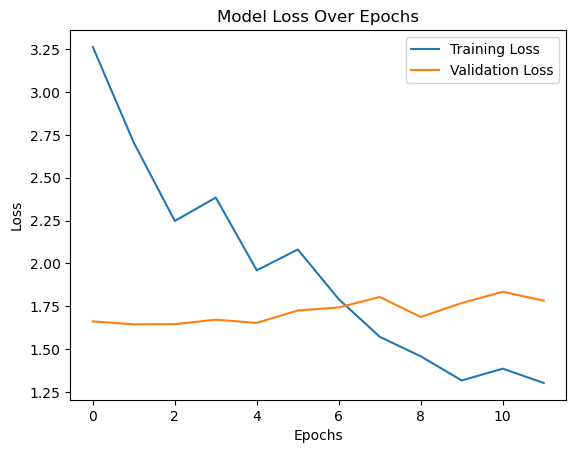

In [318]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Three Layers (Model 2)

In [107]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0119688510894775
Final Validation Loss: 2.405595541000366
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 10.149094581604004
Final Validation Loss: 10.400778770446777
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 3.1702308654785156
Final Valid

In [335]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 4.4972 - val_loss: 2.1650
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 784ms/step - loss: 3.9159 - val_loss: 2.1636
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 902ms/step - loss: 3.1941 - val_loss: 2.1655
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 932ms/step - loss: 3.1424 - val_loss: 2.1687
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 907ms/step - loss: 3.3276 - val_loss: 2.1713
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 822ms/step - loss: 3.0767 - val_loss: 2.1667
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 966ms/step - loss: 2.8963 - val_loss: 2.1622
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 945ms/step - loss: 2.9498 - val_loss: 2.1574
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 827ms/step - loss: 2.8446 - val_loss: 2.1533
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 875ms/step - loss: 2.7318 - val_loss: 2.1539
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 815ms/step - loss: 2.8244 - val_loss: 2.1507
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 826ms/step - loss: 2.7855 - val_loss

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.02047735676167616
Test RMSE: 0.025651755164508228
Training MAE: 0.014768675280961945
Test MAE: 0.019897213206732902
Directional Accuracy on Training Data: 56.13608748481167%
Directional Accuracy on Test Data: 57.84313725490197%


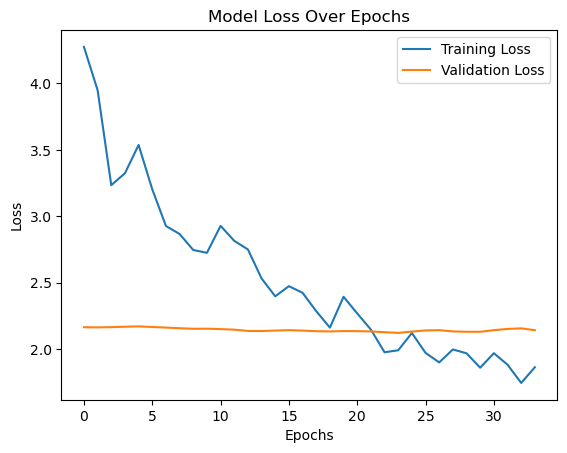

In [336]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2. Optuna (Model 3) 

In [108]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of an Bidirectional LSTM model.
    Takes a trial object from Optuna and returns the validation loss of the model with given parameters.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate for LSTM layers.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add Bidirectional LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add Bidirectional LSTM layer with specified hyperparameters.
        model.add(Bidirectional(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Set input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        )))
        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-21 17:24:31,647] A new study created in memory with name: no-name-77cc7692-5b03-400b-8337-427a2a579832
[I 2024-11-21 17:25:25,736] Trial 0 finished with value: 2.784571409225464 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.784571409225464.
[I 2024-11-21 17:26:47,271] Trial 1 finished with value: 9.031414031982422 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 2.784571409225464.
[I 2024-11-21 17:34:33,688] Trial 2 finished with value: 10.044281005859375 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0014776435986831235, 'learning_rate': 0.001, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'epochs': 100, 'batch_size': 32}
Best validation loss: 1.400141716003418


In [291]:
# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.0014776435986831235,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters.
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping.
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss.
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 2.5190 - val_loss: 1.4653
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.7906 - val_loss: 1.4763
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.4832 - val_loss: 1.4905
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.4473 - val_loss: 1.4819
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.4129 - val_loss: 1.4904
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.4090 - val_loss: 1.5249
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.2170 - val_loss: 1.5587
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.4686 - val_loss: 1.5499
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.0964 - val_loss: 1.5786
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.1570 - val_loss: 1.6316
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.0719 - val_loss: 1.6932
Final Training Loss: 1.1338869333267212
Final Valid

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.020752507860676287
Test RMSE: 0.026086591611930148
Training MAE: 0.015066503977205914
Test MAE: 0.020153737001765062
Directional Accuracy on Training Data: 49.08869987849332%
Directional Accuracy on Test Data: 51.9607843137255%


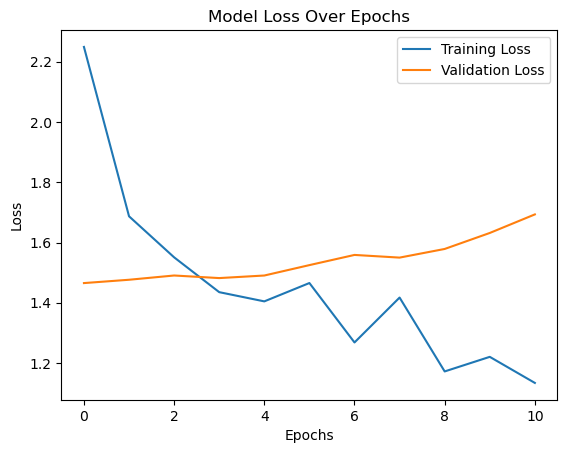

In [292]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 3. Keras Tuner (Model 4) 

In [109]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build model function with hyperparameter choices.
def build_model(hp): #hp (kerastuner.HyperParameters) - Hyperparameter search space.
    model = Sequential()
    
    # Define hyperparameters using `hp` for various tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates to fight overfitting.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout for LSTM layers.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization factor.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate choices.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay for gradual reduction.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm to prevent exploding gradients.
    units = hp.Choice("units", [32, 64, 128])  # Number of units for LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size choices.


    # Add Bidirectional LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        model.add(Bidirectional(LSTM(units=units, return_sequences=return_sequences,
                       input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
                       kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout)))
        model.add(BatchNormalization()) # Add batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Add dropout to help with overfitting.

    model.add(Dense(1))  # Output layer for a single continuous value.
    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
     # Compile model with specified optimizer and mean squared error loss.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")
    
    return model

# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_model,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of times to execute each trial.
    directory="bi_lstm_tuner_dir",  # Directory to store tuning results.
    project_name="bidirectional_lstm_tuning_capstone",  # Tuning project name.
    overwrite=True  # Overwrite existing tuner results if present.
)

# Define early stopping.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform tuning with verbose logging.
tuner.search(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1  # Ensure output of each trial.
)

# Retrieve the best model and hyperparameters.
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hyperparameters.values)
print("Best batch size:", best_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 49s]
val_loss: 1.4111263751983643

Best val_loss So Far: 1.4095014333724976
Total elapsed time: 00h 59m 40s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.001, learning_rate=0.001, learning_rate_decay=0.0, clipnorm=1.0, units=64, num_layers=1, batch_size=120
Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.001, 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'clipnorm': 1.0, 'units': 64, 'num_layers': 1, 'batch_size': 120}
Best batch size: 120


In [287]:
# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0.0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
     # Select the optimizer with specified parameters
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq), 
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - loss: 2.8036 - val_loss: 1.6315
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 2.3773 - val_loss: 1.6283
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 2.2848 - val_loss: 1.6393
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 2.1548 - val_loss: 1.6444
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 1.9913 - val_loss: 1.6370
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 1.8440 - val_loss: 1.6389
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 1.9104 - val_loss: 1.6398
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 1.8083 - val_loss: 1.6383
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 1.7660 - val_loss: 1.6375
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 1.5691 - val_loss: 1.6351
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 1.7292 - val_loss: 1.6350
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 1.

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Bidirectional LSTM Model Performance:
Training RMSE: 0.020626411024380394
Test RMSE: 0.025719786909151294
Training MAE: 0.014933531847854257
Test MAE: 0.020251108785241796
Directional Accuracy on Training Data: 50.78979343863913%
Directional Accuracy on Test Data: 58.82352941176471%


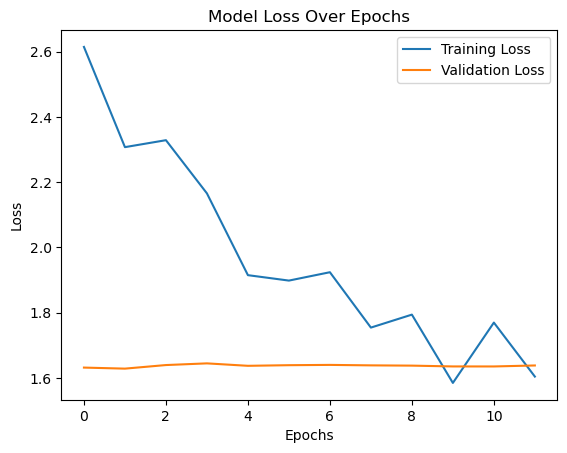

In [288]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Inverse scale predictions and actual values to original scale
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler_y.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler_y.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate metrics.
# Root Mean Squared Error (RMSE) for training set
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled)) # RMSE for test set.
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled) # Mean Absolute Error (MAE) for training set.
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled) # MAE for test set.
# Directional accuracy for training set.
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
# Directional accuracy for test set.
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display score metrics to evaluate the model's performance.
print("Bidirectional LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss values, it will help visualize how well the model fits the data over training epochs.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Cross Validation on the best performer (Model 2)

In [91]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units2'], return_sequences=True, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third Bidirectional LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(Bidirectional(LSTM(units=params['units3'], return_sequences=False, kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout'])))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_scaled)):
    print(f"Fold {fold + 1}")
    
    # Define train and test sets
    train, test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 930ms/step
Fold 1 RMSE: 1.4903867468831737
Fold 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Fold 2 RMSE: 0.7730105567743726
Fold 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Fold 3 RMSE: 0.7655759606473033
Fold 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Fold 4 RMSE: 1.2027429865827357
Average RMSE from TSCV: 1.0579290627218962


In [92]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 53    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(X_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    train = X_train_scaled[start:start + train_window]
    test = X_train_scaled[start + train_window:start + train_window + test_window]
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for train and test
    X_train_seq, y_train_seq = [], []
    for i in range(len(train) - sequence_length):
        X_train_seq.append(train[i:i + sequence_length])
        y_train_seq.append(y_train_fold[i + sequence_length])
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(test) - sequence_length):
        X_test_seq.append(test[i:i + sequence_length])
        y_test_seq.append(y_test_fold[i + sequence_length])
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Build and train the model
    model = build_best_model(best_params)
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Rolling window RMSE: 0.5343988335543942
Rolling window starting at index 53
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Rolling window RMSE: 0.4559980573474154
Rolling window starting at index 106
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Rolling window RMSE: 0.362708727534214
Rolling window starting at index 159
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Rolling window RMSE: 0.06782570107535754
Rolling window starting at index 212
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Rolling window RMSE: 0.8166474987869629
Rolling window starting at index 265
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Rolling window RMSE: 0.688751149579714
Rolling window starting at index 318
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Rolling window RMSE: 0.24319146472261047
Rolling window starting at index 371
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Rolling window RMSE: 0.2640953991312823
Rolling window starting at index 424
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Rolling window RMSE: 0.469

In [93]:
# Extracting train and val loss:
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation loss
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler_y.scale_[0] + scaler_y.mean_[0]

print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.03285685471590392
Descaled Validation Loss: 0.07311208521858037


In [94]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler_y):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler_y.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler_y)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler_y)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.03178728190058924, 0.017240987230252146, 0.017090235326982405, 0.025954706251849924]
Descaled FRWCV RMSE Values: [0.012402638138643316, 0.010812899297552279, 0.00892126405822927, 0.002941897227695383, 0.018125817011027667, 0.015532452457700612, 0.006497802913267055, 0.006921673671553334, 0.01109245671594164, 0.07260494288853689]
Average Descaled TSCV RMSE: 0.02301830267741843
Average Descaled FRWCV RMSE: 0.016585384438014744


### Bi-LSTM - Sequence Length = 52

| Metrics       | Model 1      | Model 2      | Model 3      | Model 4      |
|---------------|--------------|--------------|--------------|--------------|
| **Train RMSE** | 0.020662977  | 0.020477357  | 0.020752508  | 0.020626411  |
| **Test RMSE**  | 0.025747217  | 0.025651755  | 0.026086592  | 0.025719787  |
| **Train MAE**  | 0.015034824  | 0.014768675  | 0.015066504  | 0.014933532  |
| **Test MAE**   | 0.020209119  | 0.019897213  | 0.020153737  | 0.020251109  |
| **Train Loss** | 1.302232027  | 1.863647461  | 1.133886933  | 1.603976369  |
| **Val Loss**   | 1.782685757  | 2.142684221  | 1.693235159  | 1.638009429  |
| **Train DA**   | 61%          | 56%          | 49%          | 51%          |
| **Test DA**    | 68%          | 58%          | 52%          | 59%          |

### Descaled Metrics for Sequence Length = 52

#### TSCV RMSE Values
| Fold | RMSE              |
|------|-------------------|
| 1    | 0.031787281900589 |
| 2    | 0.017240987230252 |
| 3    | 0.017090235326982 |
| 4    | 0.025954706251850 |

**Average TSCV RMSE**: **0.02301830267741843**
- The scores shows that the model does not generalize well on the first and the last folds. 
---

#### Training and Validation Loss
| Metric              | Loss              |
|---------------------|-------------------|
| **Training Loss**   | 0.032856854715904 |
| **Validation Loss** | 0.073112085218580 |
- Overfitting might be an indication when looked at the original scale
---

By observing the metric table of the SL = 52, Model 2 appears to stand out, having the lowest RMSE and MAE (both train and test) scores. In addition, the train and val loss plot indicates good convergence and not deacresing (improving), but stable. Thus, **the optimal performer with sequence length of 12 is the Model 2**. 

## Evaluation

### Best Bi-LSTM Models by Sequence Length (SL)

| **Sequence Length (SL)** | **Best Model** | **Train RMSE** | **Test RMSE** | **Train MAE** | **Test MAE** | **Train DA** | **Test DA** |
|---------------------------|----------------|----------------|---------------|---------------|---------------|-------------|-------------|
| **4**                    | Model 1        | 0.019276805    | 0.022653612   | 0.01394871    | 0.017290756   | 69%         | 63%         |
| **12**                   | Model 3        | 0.020123816    | 0.023313899   | 0.014573091   | 0.017546967   | 67%         | 56%         |
| **26**                   | Model 3        | 0.020310553    | 0.024043852   | 0.014810702   | 0.018365903   | 65%         | 70%         |
| **52**                   | Model 2        | 0.020477357    | 0.025651755   | 0.014768675   | 0.019897213   | 56%         | 58%         |


---

### TSCV RMSE Comparison
| Sequence Length (SL) | Fold 1 RMSE   | Fold 2 RMSE   | Fold 3 RMSE   | Fold 4 RMSE   | **Average TSCV RMSE** | **Training Loss** | **Validation Loss** |
|-----------------------|---------------|---------------|---------------|---------------|------------------------|-------------------|---------------------|
| **SL = 4**           | 0.02974385    | 0.02060582    | 0.01745398    | 0.02394155    | **0.02293630**         | 0.02630015        | 0.03006664          |
| **SL = 12**          | 0.03015307    | 0.02056645    | 0.01765558    | 0.02422408    | **0.02314980**         | 0.03285685        | 0.07311209          |
| **SL = 26**          | 0.03017294    | 0.02072717    | 0.01694458    | 0.02475511    | **0.02314995**         | 0.02065414        | 0.02599376          |
| **SL = 52**          | 0.03178728    | 0.01724099    | 0.01709024    | 0.02595471    | **0.02301830**         | 0.03285685        | 0.07311209          |

---

### FRWCV RMSE Comparison
| Sequence Length (SL) | Window 1 RMSE | Window 2 RMSE | Window 3 RMSE | Window 4 RMSE | Window 5 RMSE | Window 6 RMSE | Window 7 RMSE | Window 8 RMSE | Window 9 RMSE | Window 10 RMSE | Window 11 RMSE | **Average FRWCV RMSE** |
|-----------------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|----------------|----------------|------------------------|
| **SL = 4**           | 0.02598876    | 0.02707658    | 0.01926049    | 0.01651055    | 0.01678533    | 0.01928651    | 0.01836954    | 0.01194137    | 0.01678737    | 0.02287280     | 0.02831387     | **0.02029029**         |
| **SL = 12**          | 0.02732421    | 0.02937183    | 0.02063284    | 0.01700473    | 0.01784261    | 0.01937155    | 0.01945783    | 0.01076522    | 0.01788090    | 0.02080231     | 0.02997938     | **0.02094849**         |
| **SL = 26**          | 0.01240264    | 0.01081290    | 0.00892126    | 0.00294190    | 0.01812582    | 0.01553245    | 0.00649780    | 0.00692167    | 0.01109246    | 0.07260494     | -              | **0.01658538**         |
|
---
### Best Model: Sequence Length = 26

The parameters for the best model was acquired by performing Optuna (Bayesian Optimization), the architecture is composed by a single layer with: 

- units: 128.
- recurrent_dropout: 0.1.
- optimizer: adam.
- loss_function: mean_squared_error.
- learning_rate_decay: 1e-06.
- learning_rate: 0.001.
- l2_lambda: 0.0010012325682668814.
- epochs: 200.
- dropout_rate: 0.2.
- clipnorm: 5.0.
- batch_size: 64.
- Early Stopping. 
    
To select the best model the following aspects were taken into account:
- It does not have the lowest RMSE and MAE metrics, but it is still competitive with the lowest.
- It has the highest Direction Accuracy.
- The convergence plot is the best among the models, not only having the lowest validation loss, but also the smallest gap between the training loss. Strong indication that the model is not overfitting. 
- The model achieves the lowest score in the Fixed Rolling Window Cross Validation, indicating that it performs well the data is shifted. 